Running locally


Device type [cuda:0]
Device description [Tesla K80]
memory.used [MiB], memory.free [MiB], memory.total [MiB]
11 MiB, 11430 MiB, 11441 MiB
Data is limited to [100] images
Train data size [530] test data size [170]

Classes
    id                                     name   supercategory  level
0    0                            shirt, blouse       upperbody      2
1    1                 top, t-shirt, sweatshirt       upperbody      2
2    2                                  sweater       upperbody      2
3    3                                 cardigan       upperbody      2
4    4                                   jacket       upperbody      2
5    5                                     vest       upperbody      2
6    6                                    pants       lowerbody      2
7    7                                   shorts       lowerbody      2
8    8                                    skirt       lowerbody      2
9    9                                     coat       wholebody     

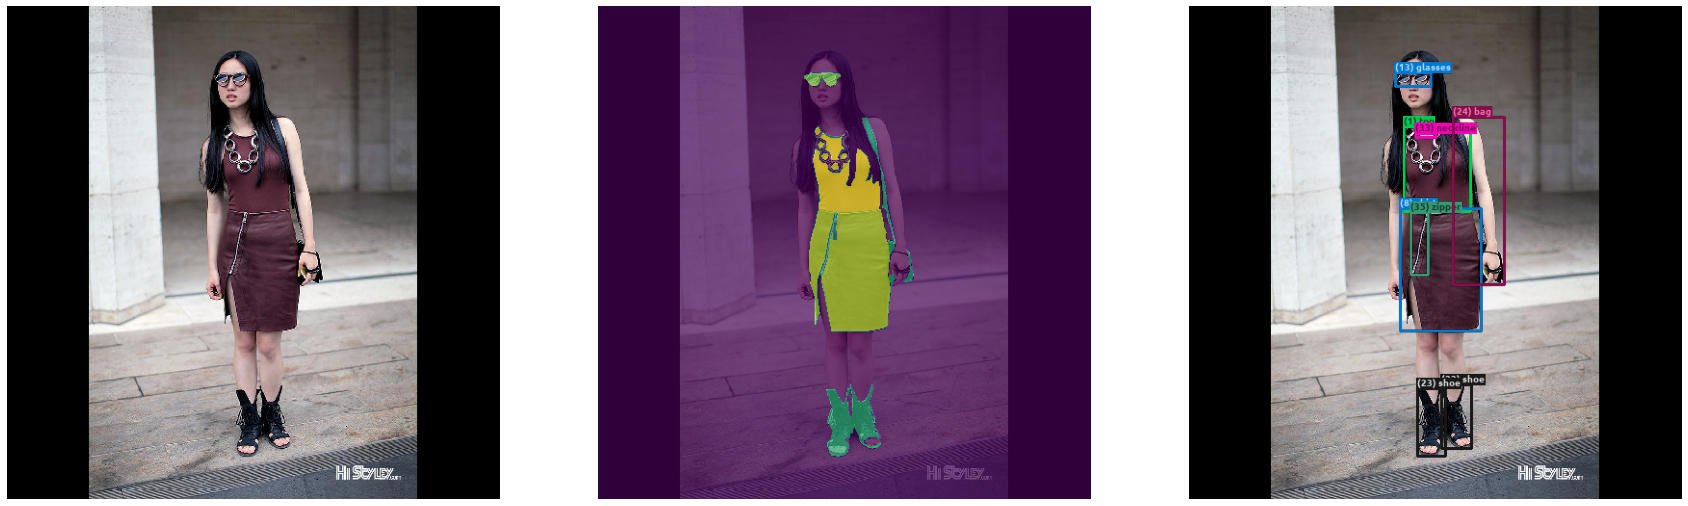

memory.used [MiB], memory.free [MiB], memory.total [MiB]
11 MiB, 11430 MiB, 11441 MiB
memory.used [MiB], memory.free [MiB], memory.total [MiB]
11 MiB, 11430 MiB, 11441 MiB


ZeroDivisionError: division by zero

In [3]:

# 1

skip_pip = True

is_colab = True
try:
    from google.colab import drive
    print("Running on Google Colab")
except:
    print("Running locally")
    is_colab = False
    
if is_colab and not skip_pip:
# if True:
    # pip install
    for pkg in ['matplotlib',
                'sklearn',
                'tensorflow',     # required by by keras
                'keras',
                'pandas',
                'opencv-python',  # cv2
                'cython',         # required by pycocotools
                'timm',
                'omegaconf',
                'timm']:          # originally was - !pip install -U timm --user
        !pip install -U $pkg

    # torchvision from ofekp repo
    # I made a change in torchvision library, so it needs to be compiled from the source code
    # I could not make this work on windows, for linux (ubuntu) use this:
    # TODO(ofekp): uninstall this and see if it is needed !pip install nvidia-ml-py
    !sudo apt install build-essential
    # torch must be installed with cuda 10.1 since the env is set up with cuda 10.1
    # also, torch is not yes supporting cuda version > 10.1 (e.g. cuda 11)
    !pip install torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
    !pip install ninja
    !pip install git+https://github.com/ofekp/vision.git
        
    # effdet from ofekp repo
    !pip install git+https://github.com/ofekp/efficientdet-pytorch.git

    # Install coco_utils
    # Win10:
    #       !pip install cython
    #       now follow this guide (Exactly!): https://github.com/philferriere/cocoapi
    #       update: I fixed support for numpy > 1.17 due to error "'numpy.float64' object cannot be interpreted as an integer"
    #       to include it use my git repo "pip install git+https://github.com/ofekp/cocoapi.git#subdirectory=PythonAPI"
    #       make sure to remove the previous version before installing from my branch by using "pip uninstall pycocotools"
    #
    # Colab/Linux: 
    !pip install cython
    !pip install -U git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

    # TODO(ofekp): this is probably not needed
    # Install segmentation package
    #!pip install -U segmentation-models-pytorch albumentations --user

    # TODO(ofekp): This is not needed since I made a change and the code is now directly in the folder
    # https://github.com/nalepae/bounding-box.git
    # !pip install bounding-box
    # !git clone https://github.com/nalepae/bounding-box.git
    # !pip uninstall -y bounding-box

import torchvision
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import json
import math
import re
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import warnings
from sklearn import svm
from keras.datasets import fashion_mnist
import pandas as pd
import joblib
import os
import random
import time
import multiprocessing
from multiprocessing import Process, Pool, Queue, Lock, Value
import itertools
import pickle
import importlib
from PIL import Image

current_time_millis = lambda: int(round(time.time() * 1000))

# imports for segmentation
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

warnings.filterwarnings('ignore')

# connect to Google Drive
if is_colab:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/gdrive')
    print("Folder content:")
    main_folder_path = '/content/gdrive/Shared drives/project_200446375_204031231/'
    main_folder_path_escaped = main_folder_path.replace(" ", "\ ")
    !ls $main_folder_path_escaped
    ofek_code_folder_imports = '/content/gdrive/Shared drives/project_200446375_204031231/code_ofek/*.{py,ttf}'
    ofek_code_folder_imports = ofek_code_folder_imports.replace(" ", "\ ")
    !cp $ofek_code_folder_imports .
else:
    main_folder_path = '../'
    %matplotlib inline
    # for local run, make the notebook wider with this code
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)

# imports external packages (from folder)
import bounding_box as bbx
import worker
import utils
import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops import misc as misc_nn_ops
import pycocotools
import coco_utils, coco_eval, engine, utils
from timm.models.layers import get_act_layer
from timm import create_model
import effdet
from effdet import BiFpn, DetBenchTrain, EfficientDet, load_pretrained, load_pretrained, HeadNet

# seeds
# following is needed for reproducibility
# refer to https://pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

# 2

def print_bold(str):
    print("\033[1m" + str + "\033[0m")


def reload_external_packages():
    return
    # reloads the package with changes
    if is_colab:
        ofek_code_folder_imports = '/content/gdrive/Shared drives/project_200446375_204031231/code_ofek/*.{py,ttf}'
        ofek_code_folder_imports = ofek_code_folder_imports.replace(" ", "\ ")
        !cp $ofek_code_folder_imports .
    importlib.reload(worker)
    importlib.reload(bbx)
    importlib.reload(torch)
    importlib.reload(torchvision)
    importlib.reload(engine)
    importlib.reload(pycocotools)
    importlib.reload(coco_utils)
    importlib.reload(coco_eval)
    importlib.reload(utils)
#     importlib.reload(efficientdet)
#     importlib.reload(efficientdet_config_model)
#     importlib.reload(efficientdet_utils)
#     importlib.reload(bench)
    importlib.reload(transforms)
#     from efficientdet_config_model import get_efficientdet_config
#     from efficientdet_utils import IntermediateLayerGetter


def get_image_path(image_id):
    if is_colab:
        # images are split into shards (folders) to avoid too many files in one folder
        shard_folder = image_id[0:2]
        return main_folder_path + f'/Data/shard/train/{shard_folder}/{image_id}.jpg'
    else:
        # non-sharded images
        return main_folder_path + f'/Data/train/{image_id}.jpg'
    
    
def get_model_identifier():
    return 'dim_' + str(target_dim) + '_images_' + str(limit_data) + '_classes_' + str(num_classes)


def get_model_file_path(prefix=None, suffix=None):
    model_file_path = get_model_identifier()
    if prefix:
        model_file_path = prefix + '_' + model_file_path
    if suffix:
        model_file_path = model_file_path + '_' + suffix
        
    model_file_path = 'Model/' + model_file_path + '.model'

    if is_colab:
        model_file_path = main_folder_path + 'code_ofek/' + model_file_path
    else:
        model_file_path = main_folder_path + 'Code/' + model_file_path
    
    return model_file_path


def get_log_file_path(prefix=None, suffix=None):
    log_file_path = get_model_identifier()
    if prefix:
        log_file_path = prefix + '_' + log_file_path
    if suffix:
        log_file_path = log_file_path + '_' + suffix
        
    log_file_path = 'Log/' + log_file_path + '.log'

    if is_colab:
        log_file_path = main_folder_path + 'code_ofek/' + log_file_path
    else:
        log_file_path = main_folder_path + 'Code/' + log_file_path
    
    return log_file_path


# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'  # TODO(ofekp): until I can train again
print("Device type [{}]".format(device))
if device == 'cuda:0':
    print("Device description [{}]".format(torch.cuda.get_device_name(0)))
    
!nvidia-smi --query-gpu=memory.used,memory.free,memory.total --format=csv

# 3

# TODO(ofekp): these should be None to avoid limiting
limit_data = 100
allowed_classes = None  # np.array([0,1,6,9,10,20,23,24,31,32,33])

with open(main_folder_path + '/Data/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
sample_sub_df = pd.read_csv(main_folder_path + '/Data/sample_submission.csv')
data_df = pd.read_csv(main_folder_path + '/Data/train.csv')
cut_data_df = data_df
if allowed_classes is not None:
    print("Data is limited to segments for these class ids {} entires".format(allowed_classes))
    cut_data_df = cut_data_df[cut_data_df['ClassId'].isin(allowed_classes)]
    cut_data_df['ClassId'] = cut_data_df['ClassId'].apply(lambda x: np.where(allowed_classes == x)[0][0])

image_ids = cut_data_df['ImageId'].unique()
image_ids_cut = image_ids

if limit_data is not None:
    print("Data is limited to [{}] images".format(limit_data))
    image_ids_cut = image_ids[:limit_data]

image_train_count = int(len(image_ids_cut) * 0.8)
image_ids_train = image_ids_cut[:image_train_count]
image_ids_test = image_ids_cut[image_train_count:]
assert len(image_ids_cut) == (len(image_ids_test) + len(image_ids_train))
cut_data_df = cut_data_df[cut_data_df['ImageId'].isin(image_ids_cut)]
train_df = cut_data_df[cut_data_df['ImageId'].isin(image_ids_train)]
test_df = cut_data_df[cut_data_df['ImageId'].isin(image_ids_test)]
assert len(cut_data_df) == (len(test_df) + len(train_df))

print("Train data size [{}] test data size [{}]".format(len(train_df), len(test_df)))
print()
num_classes = None
if allowed_classes is None:
  num_classes = len(data_df['ClassId'].unique())
else:
  num_classes = len(allowed_classes)
num_attributes = len(label_desc['attributes'])
print_bold("Classes")
categories_df = pd.DataFrame(label_desc['categories'])
if allowed_classes is not None:
    allowed_col = categories_df['id'].isin(allowed_classes)
    allowed_col = categories_df['id'].isin(allowed_classes)
    d = {True: 'V', False: ''}
    allowed_col = allowed_col.replace(d)
    categories_df['is_allowed'] = allowed_col
attributes_df = pd.DataFrame(label_desc['attributes'])
print(categories_df)
print(f'Total # of classes: {num_classes}')
print()
print_bold("Attributes")
print(attributes_df.head())
print(f'Total # of attributes: {num_attributes}')
print()

train_df.head()

!nvidia-smi --query-gpu=memory.used,memory.free,memory.total --format=csv

# 4

reload_external_packages()

target_dim = (2 ** 6) * 8  # it is vital that the image size will be devisiable by 2 at least 5 times
font = bbx.get_font_with_size(10)
print("Setting target_dim to [{}]".format(target_dim))


# generate a map from the class id to the label
def get_label(class_id):
    if allowed_classes is not None:
        class_id = allowed_classes[class_id]
    class_name = categories_df.loc[class_id]['name']
    label = class_name
    if ',' in class_name:
        label = class_name.split(',')[0]
    label = "(" + str(class_id) + ") " + label
    return label


def get_image_bounding_boxes(width, height, bounding_boxes, labels, decode_labels=True):
    if target_dim == None:
        image_with_bb = np.zeros((height, width, 3))
    else:
        image_with_bb = np.zeros((target_dim, target_dim, 3))
    
    for box, class_id in zip(bounding_boxes, labels):
        class_id = class_id.cpu().numpy()
        bbx.add(image_with_bb, *box, label=(get_label(class_id) if decode_labels else str(class_id)), font=font)

    # creating the alpha channel for the bounding box image (to avoid obscuring the original image with black background)
    bb_alpha = np.array(np.max(image_with_bb[:,:,:] > 0, axis=2) > 0, dtype=int)
    bb_alpha = bb_alpha * 255
    image_with_bb = np.concatenate((image_with_bb, bb_alpha.reshape(bb_alpha.shape[0], bb_alpha.shape[1], 1)), axis=2)
    image_with_bb = np.array(image_with_bb, dtype=int)
    return image_with_bb


def show_image_data_ground_truth(data_df, image_id, figsize=(30, 30)):
    # Get the an image id given in the training set for visualization
    vis_df = data_df[data_df['ImageId'] == image_id]
    vis_df = vis_df.reset_index(drop=True)
    class_ids = worker.get_labels(vis_df)
    masks = worker.get_masks(vis_df, target_dim=target_dim)
    bounding_boxes = worker.get_bounding_boxes(vis_df, masks)
    class_ids, masks, bounding_boxes = worker.remove_empty_masks(class_ids, masks, bounding_boxes)
    # img = mpimg.imread(get_image_path(image_id))
    img = Image.open(get_image_path(image_id)).convert("RGB")
    img = worker.rescale(img, target_dim=target_dim)
    show_image_data(img, class_ids, masks, bounding_boxes, figsize=figsize)


def show_image_data(img, class_ids, masks, bounding_boxes, figsize=(30, 30)):
    height = img.shape[2]
    width = img.shape[1]
    image_with_bb = get_image_bounding_boxes(width, height, bounding_boxes, class_ids)
    
    if target_dim == None:
        mask = torch.zeros((height, width))
    else:
        mask = torch.zeros((target_dim, target_dim))
    
    # generate the segments mask with colors
    if masks is not None:
        for i, (curr_mask, class_id) in enumerate(zip(masks, class_ids)):
            curr_mask = curr_mask.cpu()
            class_id = class_id.cpu()
            assert torch.min(curr_mask) >= 0.0
            assert torch.max(curr_mask) <= 1.0
            curr_mask = curr_mask.type(torch.FloatTensor)
            mask = torch.where(curr_mask == 0, mask, curr_mask * (255 - 4 * class_id))
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(img.permute(1, 2, 0))
    ax[1].imshow(mask, alpha=0.7)
    ax[1].axis('off')
    ax[2].imshow(img.permute(1, 2, 0))
    ax[2].imshow(image_with_bb)
    ax[2].axis('off')
    plt.show()


image_id = train_df.iloc[25]['ImageId']
# image_id = '000b3ec2c6eaffb491a5abb72c2e3e26'
# image_id = '0066d8d66ec36bdb91592fdc4aa17ed9'
# image_id = '029720c77ebda81f6a57efd7a34df406'
# image_id = 'd3602308d5894f1a6ee0632a98321ca3'
# image_id = '361cc7654672860b1b7c85fe8e92b38a'
# image_id = '0000fe7c9191fba733c8a69cfaf962b7'
# image_id = '04c0dd48d11b43bfab3a0651582dd3ad'
# image_id = '0556dd69fa22ca23e438cb8ce944fcb8'
show_image_data_ground_truth(train_df, image_id)

!nvidia-smi --query-gpu=memory.used,memory.free,memory.total --format=csv

# 5

reload_external_packages()


def inc_by(lock, counter, val):
    lock.acquire()
    try:
        counter.value += val
    finally:
        lock.release()


def get_transform(train):
    transforms = []
#     transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomGreyscale(0.1))
    return T.Compose(transforms)


class IMATDataset(BaseDataset):
    def __init__(self, data_df, transforms=None):
        self.transforms = transforms
        self.data_df = data_df
        self.image_ids = data_df['ImageId'].unique()
        self.skipped_images = []
        self.lock = Lock()
        self.images_processed = Value('i', 0)
        self.total_transform_time = Value('f', 0.0)
        self.total_mask_time = Value('f', 0.0)
        self.total_box_time = Value('f', 0.0)
        self.total_process_time = Value('f', 0.0)
        self.total_image_load_time = Value('f', 0.0)
        # TODO: indices = torch.randperm(len(dataset)).tolist()
        
    def show_stats(self):
        images_processed = self.images_processed.value
        total_process_time = self.total_process_time.value
        avg_time_per_image = 0 if images_processed == 0 else total_process_time / images_processed
        avg_image_load_time = 0 if images_processed == 0 else self.total_image_load_time.value / images_processed
        avg_transform_time = 0 if images_processed == 0 else self.total_transform_time.value / images_processed
        avg_mask_time = 0 if images_processed == 0 else self.total_mask_time.value / images_processed
        avg_box_time = 0 if images_processed == 0 else self.total_box_time.value / images_processed
        print("Processed [{}] images in [{}] seconds."
              "Avg of [{}] per image."
              "Avg image load time [{}]"
              "Avg transform time [{}]"
              "Avg mask time [{}]"
              "Avg box time [{}]"
              .format(
            images_processed,
            total_process_time,
            avg_time_per_image,
            avg_image_load_time,
            avg_transform_time,
            avg_mask_time,
            avg_box_time))
    
    def __getitem__(self, idx):
        start = time.time()
        image_id = self.image_ids[idx]
        vis_df = self.data_df[self.data_df['ImageId'] == image_id]
        vis_df = vis_df.reset_index(drop=True)
        labels = worker.get_labels(vis_df)
        mask_start_ts = time.time()
        try:
            masks = worker.get_masks(vis_df, target_dim=target_dim)
            for mask in masks:
                assert not torch.any(torch.isnan(mask))
                assert len(mask.nonzero()) == torch.sum(mask)  # check only ones and zeros
        except Exception as e:
            self.skipped_images.append(image_id)
            print("ERROR: Skipped image with id [{}] due to a mask exception [{}]".format(image_id, e))
            return
        inc_by(self.lock, self.total_mask_time, time.time() - mask_start_ts)
        
        box_start_ts = time.time()
        boxes = worker.get_bounding_boxes(vis_df, masks)
        try:
            for box in boxes:
                assert not torch.any(torch.isnan(box))
        except Exception as e:
            self.skipped_images.append(image_id)
            print("ERROR: Skipped image with id [{}] due to a BB exception [{}]".format(image_id, e))
            return
        inc_by(self.lock, self.total_box_time, time.time() - box_start_ts)
        
        num_objs = len(labels)

        image_id_idx = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        labels, masks, boxes = worker.remove_empty_masks(labels, masks, boxes)

        target = {}
        target["labels"] = torch.add(labels, 1)  # refer to fast_collate, this is needed for efficient det
        assert torch.min(target["labels"]) >= 1
        assert torch.max(target["labels"]) <= num_classes
        target["masks"] = masks
        target["boxes"] = boxes
        target["image_id"] = image_id_idx
        target["area"] = area
        target["iscrowd"] = iscrowd
#         target["image_id"] = torch.tensor(image_id_idx)
#         target["area"] = torch.tensor(area)
#         target["iscrowd"] = torch.tensor(iscrowd)

        image_load_start_ts = time.time()
        image_orig = Image.open(get_image_path(image_id)).convert("RGB")
        # image = mpimg.imread(get_image_path(image_id))
        image = worker.rescale(image_orig, target_dim=target_dim)
        inc_by(self.lock, self.total_image_load_time, time.time() - image_load_start_ts)
        
        # TODO(ofekp): make sure that this makes sense!
        # TODO(ofekp): check what happens here when the image is < target_dim. What will worker.py scale method do to the image in this case?
        target["img_size"] = image_orig.size[-2:] if target_dim is None else (target_dim, target_dim)
        image_orig_max_dim = max(target["img_size"])
        img_scale = target_dim / image_orig_max_dim
        target["img_scale"] = 1. / img_scale  # back to original size
        
        transform_start_ts = time.time()
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        inc_by(self.lock, self.total_transform_time, time.time() - transform_start_ts)

        inc_by(self.lock, self.images_processed, 1)
        inc_by(self.lock, self.total_process_time, time.time() - start)
        assert image.shape[0] <= target_dim and image.shape[1] <= target_dim and image.shape[2] <= target_dim
        return image, target

    def __len__(self):
        return len(self.image_ids)
    
!nvidia-smi --query-gpu=memory.used,memory.free,memory.total --format=csv

# 6

def set_bn_eval(m):
    classname = m.__class__.__name__
    if "BatchNorm2d" in classname:
        m.affine = False
        m.weight.requires_grad = False
        m.bias.requires_grad = False
        m.eval()


def freeze_bn(model):
    model.apply(set_bn_eval)
    

def get_model_instance_segmentation(num_classes):
    from ipywidgets import FloatProgress
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model


class EfficientDetBB(nn.Module):

    def __init__(self, config, class_net, box_net):
        super(EfficientDetBB, self).__init__()
        self.class_net = class_net
        self.box_net = box_net

    def forward(self, x):
        '''
        Originally EfficientDet also conatined the backbone and then fpn
        but for the pupose of out network this had to be modified
        '''
        x_class = self.class_net(x)
        x_box = self.box_net(x)
        return x_class, x_box

    
class BackboneWithCustomFPN(nn.Module):
    def __init__(self, config, backbone, fpn, out_channels, alternate_init=False):
        super(BackboneWithCustomFPN, self).__init__()
        self.body = backbone
        self.fpn = fpn
        self.out_channels = out_channels
        
        for n, m in self.named_modules():
            if 'body' not in n and 'backbone' not in n:  # avoid changing the weights of the backbone which is pretrained
                if alternate_init:
                    effdet._init_weight_alt(m, n)
                else:
                    effdet._init_weight(m, n)

    def forward(self, x):
        '''
        Args:
            x - in BCHW format, e.g. x.shape = torch.Size([2, 3, 512, 512])
        '''
        x = self.body(x)  # len(x) = 3
        x = self.fpn(x)
        # at this point x is an OrderedDict of features
        return x


def get_model_instance_segmentation_efficientnet(num_classes, freeze_batch_norm=False):
    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#     anchor_generator = AnchorGenerator(sizes=((64, 176, 512, 288, 288),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    
    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    # TODO(ofekp): follow where this is being used!
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                    output_size=7,
                                                    sampling_ratio=2)
    # ofekp: note that roi_pooler is passed to box_roi_pooler in the MaskRCNN network and is not being used in roi_heads.py
    
    mask_roi_pool = MultiScaleRoIAlign(
                featmap_names=[0, 1, 2, 3],
                output_size=14,
                sampling_ratio=2)
    
    config = effdet.get_efficientdet_config('tf_efficientdet_d0')  # TODO(ofekp): use 'tf_efficientdet_d7' or try to decrease to smaller model so that we can fit 16 images in one batch
    efficientDetModelTemp = EfficientDet(config, pretrained_backbone=False)
    load_pretrained(efficientDetModelTemp, config.url)
    config.num_classes = num_classes
    config.image_size = target_dim

    out_channels = config.fpn_channels  # This is since the config of 'tf_efficientdet_d5' creates fpn outputs with num of channels = 288
    backbone_fpn = BackboneWithCustomFPN(config, efficientDetModelTemp.backbone, efficientDetModelTemp.fpn, out_channels)  # TODO(ofekp): pretrained! # from the repo trainable_layers=trainable_backbone_layers=3
    model = MaskRCNN(backbone_fpn,
                 min_size=target_dim,
                 max_size=target_dim,
                 num_classes=num_classes,
                 mask_roi_pool=mask_roi_pool,
#                  rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler)
    
    # for training with different number of classes (default is 90) we need to add this line
    # TODO(ofekp): check if we need to init weights here
    class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    efficientDetModel = EfficientDetBB(config, class_net, efficientDetModelTemp.box_net)
    model.roi_heads.box_predictor = DetBenchTrain(efficientDetModel, config)
#     # get number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     print(in_features)
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
#     # get number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256  # TODO(ofekp): was 256
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    if freeze_batch_norm:
        # we only freeze BN layers in backbone and the BiFPN
        print("Freezing batch normalization weights")
        freeze_bn(model.backbone)

    return model


# 7


def show_prediction_on_img(dataset, dataset_df, img_idx, show_groud_truth=True, box_threshold=0.001):
    img, _ = dataset[img_idx]  # TODO(ofekp): should take from 'dataset_test'
#     img_formatted = img.mul(255).permute(1, 2, 0).byte().cpu().numpy()

    # put the model in evaluation mode
    with torch.no_grad():
        prediction = model([img.to(device)], box_threshold=box_threshold)

    # class_ids, masks, boxes = worker.remove_empty_masks(class_ids, masks, boxes)
    boxes = prediction[0]['boxes']
    class_ids = prediction[0]['labels']
    masks = prediction[0]['masks'][:, 0]
    if show_groud_truth:
        show_image_data_ground_truth(dataset_df, dataset.image_ids[img_idx])
    show_image_data(img, class_ids, masks, boxes)

    
    
class Trainer:
    
    def __init__(self, model, device, config):
        self.model = model
        self.device = device
        self.config = config
        self.optimizer = config.optimizer_class(self.model.parameters(), **config.optimizer_config)
        self.scheduler = config.scheduler_class(self.optimizer, **config.scheduler_config)
        self.model_file_path = get_model_file_path(suffix=config.model_name_suffix)
        self.log_file_path = get_log_file_path(suffix=config.model_name_suffix)
        self.epoch = 0
        self.log('Trainer initiallized. Device is [{}]'.format(self.device))
    
    def save_model(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
#             'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)        
        self.log('Saved model to [{}]'.format(path))

    
    def load_model(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#         self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        self.log("Loaded model file [{}]".format(path))
        

    def eval_and_save_model(self, data_loader_test, dataset_test, test_df):
        if (self.epoch) % self.config.save_every == 0:
            self.save_model(self.model_file_path)
            !nvidia-smi --query-gpu=memory.used,memory.free,memory.total --format=csv
            dataset_test.show_stats()
            model.eval()
            with torch.no_grad():
                show_prediction_on_img(dataset_test, test_df, 1, show_groud_truth=False, box_threshold=self.config.box_threshold)  # TODO(ofekp): This should be test_df and dataset_test
                # evaluate on the test dataset
                engine.evaluate(self.model, data_loader_test, device=self.device)

                
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_file_path, 'a+') as logger:
            logger.write(f'{message}\n')
            

    def train(self):
        # use our dataset and defined transformations
        dataset = IMATDataset(train_df, get_transform(train=True))
        dataset_test = IMATDataset(test_df, get_transform(train=False))
        
        # TODO(ofekp): do we need this?
        # split the dataset in train and test set
        # indices = torch.randperm(len(dataset)).tolist()
        # dataset = torch.utils.data.Subset(dataset, indices[:-50])
        # dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
        
        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.config.batch_size, shuffle=True, num_workers=self.config.num_workers,
            collate_fn=utils.collate_fn)

        data_loader_test = torch.utils.data.DataLoader(
            dataset_test, batch_size=self.config.batch_size, shuffle=False, num_workers=self.config.num_workers,
            collate_fn=utils.collate_fn)

        for _ in range(self.config.num_epochs):
            # tarin one epoch
            metric_logger = engine.train_one_epoch(
                self.model,
                self.optimizer,
                data_loader,
                self.device,
                self.epoch,
                gradient_accumulation_steps=self.config.gradient_accumulation_steps,
                print_freq=100,
                box_threshold=self.config.box_threshold)

            # update the learning rate
            self.scheduler.step(metric_logger.__getattr__('loss').avg)

            self.eval_and_save_model(data_loader_test, dataset_test, test_df)

            self.log("Epoch [{}/{}]".format(self.epoch + 1, self.config.num_epochs))
            self.epoch += 1

        self.log("Saving model one last time")
        self.eval_and_save_model(data_loader_test, dataset_test, test_df)
        self.log("That's it!")

        
class TrainConfig:
    model_name_suffix = os.getlogin() + "_effdet"
    verbose = True
    save_every = 10  # will also do model eval
    box_threshold = 0.3
    # TODO(ofekp): check if we need box_threshold_train = 0.1
    gradient_accumulation_steps = 2
    batch_size = 12
    num_workers = 4  # TODO: num_workers was 4
    num_epochs = 120
    
    # optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00005)  # TODO(ofekp): was lr=0.005
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    optimizer_class = torch.optim.AdamW
    optimizer_config = dict(
        lr=0.01,
        weight_decay=0.00005
    )
    
    scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_config = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    
# load a saved model
# path = get_model_file_path()
# trainer.load_model(path)
1/0
# get the model using our helper function
# model = get_model_instance_segmentation(num_classes)
model = get_model_instance_segmentation_efficientnet(num_classes, freeze_batch_norm=True)
trainer = Trainer(model, device, config=TrainConfig)
model.to(device)
trainer.train()

In [11]:
with torch.no_grad():
    engine.evaluate(model, data_loader_test, device=device, box_threshold=0.3)

ERROR: Image [0473ebd05fb0779d61030ff1a091761d] x_left [tensor(222)] y_top [tensor(230)] x_right [tensor(222)] y_bottom [tensor(230)]
ERROR: Image [048acf00d7fcdb90e8b518187424c234] contains [1] segments that were erased due to rescaling with target_dim [512]
ERROR: Image [048acf00d7fcdb90e8b518187424c234] x_left [tensor(303)] y_top [tensor(269)] x_right [tensor(303)] y_bottom [tensor(269)]
ERROR: Image [04962720541626db6ac78e45c7a465c3] x_left [tensor(295)] y_top [tensor(294)] x_right [tensor(295)] y_bottom [tensor(294)]
ERROR: Image [04c0dd48d11b43bfab3a0651582dd3ad] x_left [tensor(282)] y_top [tensor(133)] x_right [tensor(285)] y_bottom [tensor(133)]
ERROR: Image [04e9edf7c329f1c5f38bbd1d916e606b] x_left [tensor(238)] y_top [tensor(276)] x_right [tensor(238)] y_bottom [tensor(276)]
ERROR: Image [0556dd69fa22ca23e438cb8ce944fcb8] x_left [tensor(318)] y_top [tensor(402)] x_right [tensor(320)] y_bottom [tensor(402)]
ERROR: Image [05862e2154f0535f20b680527edd6f2f] contains [1] segments 

In [3]:
model.eval()
for i in range(10):
#     show_prediction_on_img(dataset, train_df, i, box_threshold=box_threshold)
    show_prediction_on_img(dataset_test, test_df, i, box_threshold=0.4)

NameError: name 'dataset_test' is not defined

In [4]:
for i in range(10):
#     show_prediction_on_img(dataset, train_df, i*10, box_threshold=box_threshold)
    show_prediction_on_img(dataset_test, test_df, i, box_threshold=0.3)

NameError: name 'dataset_test' is not defined

In [3]:
# # check transforms
# for i in range(10):
#     dataset = IMATDataset(train_df, get_transform(train=True))
#     for i, (img, target) in enumerate(dataset):
#         show_image_data(img, target['labels'], target['masks'], target['boxes'])
#         print(target['area'])
#         print(target['labels'])
#         break

# check stats
dataset = IMATDataset(train_df, get_transform(train=True))
print(len(dataset))
for i, (img, target) in enumerate(dataset):
    print(img.shape)  # print the shape of the image
#     print(d)
#     print(d[1]['boxes'].shape)
#     print(d[1]['labels'].shape)
#     print(d[1]['masks'].shape)
#     print(d[1]['area'].shape)
    print(target['img_scale'])
    if i == 19:
        break
dataset.show_stats()
# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])

80
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
Processed [20] images in [11.5634765625] seconds.Avg of [0.578173828125] per image.Avg image load time [0.07754209041595458]Avg transform time [0.020224571228027344]Avg mask time [0.474075984954834]Avg box time [0.003276228904724121]


In [171]:
# h5py

# !pip install h5py

import h5py
import numpy as np

class DatasetH5Reader(torch.utils.data.Dataset):
    def __init__(self, in_file):
        super(DatasetH5Reader, self).__init__()
        
        self.h5py_file = h5py.File(in_file, "r", swmr=True)  # swmr=True allows concurrent reads
#         self.n_images, self.nx, self.ny = self.file['images'].shape

    def __getitem__(self, index):
        image = self.h5py_file['images'][index]
        labels = self.h5py_file['labels'][index]
        masks_fixed_size = self.h5py_file['masks'][index]
        boxes_fixed_size = self.h5py_file['boxes'][index]
        return image, labels, masks_fixed_size, boxes_fixed_size

    def __len__(self):
        return self.n_images

    
class DatasetH5Writer(torch.utils.data.Dataset):
    def __init__(self, dataset, out_file, chunk_size):
        super(DatasetH5Writer, self).__init__()
#         print(data_df['ImageId'])
#         self.image_ids = data_df['ImageId'].unique()
#         print(self.image_ids)
        self.lock = Lock()
        self.chunk_size = chunk_size
        self.images_processed = Value('i', 0)
        self.total_process_time = Value('f', 0.0)
        self.file_name = out_file
        if os.path.exists(self.file_name):
            os.remove(self.file_name)
        self.h5py_file = h5py.File(self.file_name, "a")
        self.images_data_set = self.h5py_file.create_dataset("images", shape=(0, 3, target_dim, target_dim), dtype=np.float64, maxshape=(None, 3, target_dim, target_dim), chunks=(self.chunk_size, 3, target_dim, target_dim))
        dt = h5py.vlen_dtype(np.dtype('int64'))
        self.labels_data_set = self.h5py_file.create_dataset("labels", shape=(0,), maxshape=(None,), dtype=dt, chunks=(self.chunk_size,))
        
#         rowtype = np.dtype([('f0', 'int8', (51,51))])
#         dt = h5py.special_dtype( vlen=np.dtype(rowtype) )
#         dt = h5py.vlen_dtype(rowtype)
#         dt = np.dtype([('FieldA', 'int8', (4,)), ('FieldB', 'int32') ] )
        self.masks_data_set = self.h5py_file.create_dataset("masks", shape=(0,75,target_dim,target_dim), maxshape=(None,75,512,512), dtype=np.uint8, chunks=(self.chunk_size,75,target_dim,target_dim))
#         float32_t = h5py.special_dtype(vlen=np.dtype('int8'))
#         self.masks_data_set = self.h5py_file.create_dataset('masks', shape=(1, 3,), maxshape=(None, 3,), dtype=float32_t, chunks=(self.chunk_size, None, target_dim, target_dim))
        self.boxes_data_set = self.h5py_file.create_dataset("boxes", shape=(0,75,4), maxshape=(None,75,4), dtype=np.float64, chunks=(self.chunk_size,75,4))

    def tensor_list_to_numpy(self, tensor_list):
        num_of_tensors = len(tensor_list)
        if num_of_tensors == 0:
            return torch.tensor([])
        tensor_shape = tensor_list[0].shape
        for i, _ in enumerate(tensor_list):
            tensor_list[i] = tensor_list[i].unsqueeze(0)

        res_tensor = torch.Tensor(num_of_tensors, *tensor_shape)
        torch.cat(tensor_list, out=res_tensor)
        return res_tensor.numpy()
    
    def append_to_h5py(self, lock, images_np, labels_numpy_list, masks_numpy_fixed_size, boxes_numpy_fixed_size):
        assert images_np.shape[0] == self.chunk_size
        assert len(masks_numpy_fixed_size) == self.chunk_size
        lock.acquire()
        try:
            curr_len = self.images_data_set.shape[0]
            self.images_data_set.resize(curr_len + self.chunk_size, axis=0)
            self.images_data_set[-self
                                 .chunk_size:] = images_np
            
            self.labels_data_set.resize(curr_len + self.chunk_size, axis=0)
            for i, labels_numpy in enumerate(labels_numpy_list):
                self.labels_data_set[curr_len + i] = labels_numpy
            
            self.masks_data_set.resize(curr_len + self.chunk_size, axis=0)
            self.masks_data_set[-self.chunk_size:] = masks_numpy_fixed_size

            self.boxes_data_set.resize(curr_len + self.chunk_size, axis=0)
            self.boxes_data_set[-self.chunk_size:] = boxes_numpy_fixed_size
        finally:
            lock.release()
    
    def process(self):
        images = []
        labels_numpy_list = []
        masks_numpy_list = []
        boxes_numpy_list = []
        for idx in range(self.chunk_size):
            image, target = dataset.__getitem__(idx)
            images.append(image)
            labels_numpy_list.append(target["labels"].numpy())
            masks_numpy_list.append(target["masks"].numpy())
            boxes_numpy_list.append(target["boxes"].numpy())
        images_numpy = self.tensor_list_to_numpy(images)
        masks_numpy_fixed_size = np.zeros((self.chunk_size, 75, target_dim, target_dim), dtype=np.uint8)
        for i, masks_numpy in enumerate(masks_numpy_list):
            for j, mask in enumerate(masks_numpy):
                masks_numpy_fixed_size[i, j, :, :] = mask
        boxes_numpy_fixed_size = np.zeros((self.chunk_size, 75, 4), dtype=np.float64)
        for i, boxes_numpy in enumerate(boxes_numpy_list):
            for j, box in enumerate(boxes_numpy):
                boxes_numpy_fixed_size[i, j, :] = box
        self.append_to_h5py(self.lock, images_numpy, labels_numpy_list, masks_numpy_fixed_size, boxes_numpy_fixed_size)
        self.h5py_file.close()
    
#     def create_image_data(self, idx):
#         start = time.time()
#         image_id = self.image_ids[idx]
#         vis_df = self.data_df[self.data_df['ImageId'] == image_id]
#         vis_df = vis_df.reset_index(drop=True)
#         labels = worker.get_labels(vis_df)
#         try:
#             masks = worker.get_masks(vis_df, target_dim=target_dim)
#             for mask in masks:
#                 assert not torch.any(torch.isnan(mask))
#                 assert len(mask.nonzero()) == torch.sum(mask)  # check only ones and zeros
#         except Exception as e:
#             self.skipped_images.append(image_id)
#             print("ERROR: Skipped image with id [{}] due to a mask exception [{}]".format(image_id, e))
#             return
        
#         boxes = worker.get_bounding_boxes(vis_df, masks)
#         try:
#             for box in boxes:
#                 assert not torch.any(torch.isnan(box))
#         except Exception as e:
#             self.skipped_images.append(image_id)
#             print("ERROR: Skipped image with id [{}] due to a BB exception [{}]".format(image_id, e))
#             return
        
#         num_objs = len(labels)

#         image_id_idx = idx
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

#         labels, masks, boxes = worker.remove_empty_masks(labels, masks, boxes)

#         target = {}
#         target["labels"] = torch.add(labels, 1)  # refer to fast_collate, this is needed for efficient det
#         assert torch.min(target["labels"]) >= 1
#         assert torch.max(target["labels"]) <= num_classes
#         target["masks"] = masks
#         target["boxes"] = boxes
#         target["image_id"] = image_id_idx
#         target["area"] = area
#         target["iscrowd"] = iscrowd
# #         target["image_id"] = torch.tensor(image_id_idx)
# #         target["area"] = torch.tensor(area)
# #         target["iscrowd"] = torch.tensor(iscrowd)

#         image_orig = Image.open(get_image_path(image_id)).convert("RGB")
#         # image = mpimg.imread(get_image_path(image_id))
#         image = worker.rescale(image_orig, target_dim=target_dim)
        
#         # TODO(ofekp): make sure that this makes sense!
#         # TODO(ofekp): check what happens here when the image is < target_dim. What will worker.py scale method do to the image in this case?
#         target["img_size"] = image_orig.size[-2:] if target_dim is None else (target_dim, target_dim)
#         image_orig_max_dim = max(target["img_size"])
#         img_scale = target_dim / image_orig_max_dim
#         target["img_scale"] = 1. / img_scale  # back to original size

#         assert image.shape[0] <= target_dim and image.shape[1] <= target_dim and image.shape[2] <= target_dim
        
#         inc_by(self.lock, self.images_processed, 1)
#         inc_by(self.lock, self.total_process_time, time.time() - start)

#         return image, target

In [165]:
dataset = IMATDataset(train_df, get_transform(train=False))
dataset_test = IMATDataset(test_df, get_transform(train=False))

h5_writer = DatasetH5Writer(dataset, "../imaterialist_" + str(target_dim) + ".hdf5", chunk_size=20)
h5_writer.process()  # process a chunk

h5_reader = DatasetH5Reader("../imaterialist_" + str(target_dim) + ".hdf5")
h5_reader.__getitem__(0)(0).shape

AttributeError: 'tuple' object has no attribute 'shape'

In [56]:
a = torch.randn(10,5)
b = torch.randn(8,5)
a = a.unsqueeze(0)
b = b.unsqueeze(0)
res_tensor = torch.Tensor(2, 10, 5)
torch.cat([a,b], out=res_tensor)

RuntimeError: Sizes of tensors must match except in dimension 0. Got 10 and 8 in dimension 1 (The offending index is 1)

In [137]:
print(data_df['ImageId'].value_counts()[:10].index.tolist())
print(len(data_df[data_df['ImageId'] == '361cc7654672860b1b7c85fe8e92b38a']))
print(len(data_df[data_df['ImageId'] == '7cf836aab94cde732a337bbd969379fb']))
print(len(data_df[data_df['ImageId'] == 'b7d1d6947d932192acfb98aac2efb622']))
print(len(data_df[data_df['ImageId'] == '46d4674b701a9df098c2bc87d7951f2f']))

['361cc7654672860b1b7c85fe8e92b38a', '7cf836aab94cde732a337bbd969379fb', 'b7d1d6947d932192acfb98aac2efb622', '46d4674b701a9df098c2bc87d7951f2f', '94f8ed8e4f2ff4662c720a3e160dee09', 'd97d311abb6f2e4333c99db2e898b7d8', '3079ede5663f15e7d4342fe960025fac', '05927a3c798601787355d90092683774', 'd77e872590184f512bf36ca671967601', '9abed18e16d7453bccb432811794dcad']
74
55
54
54


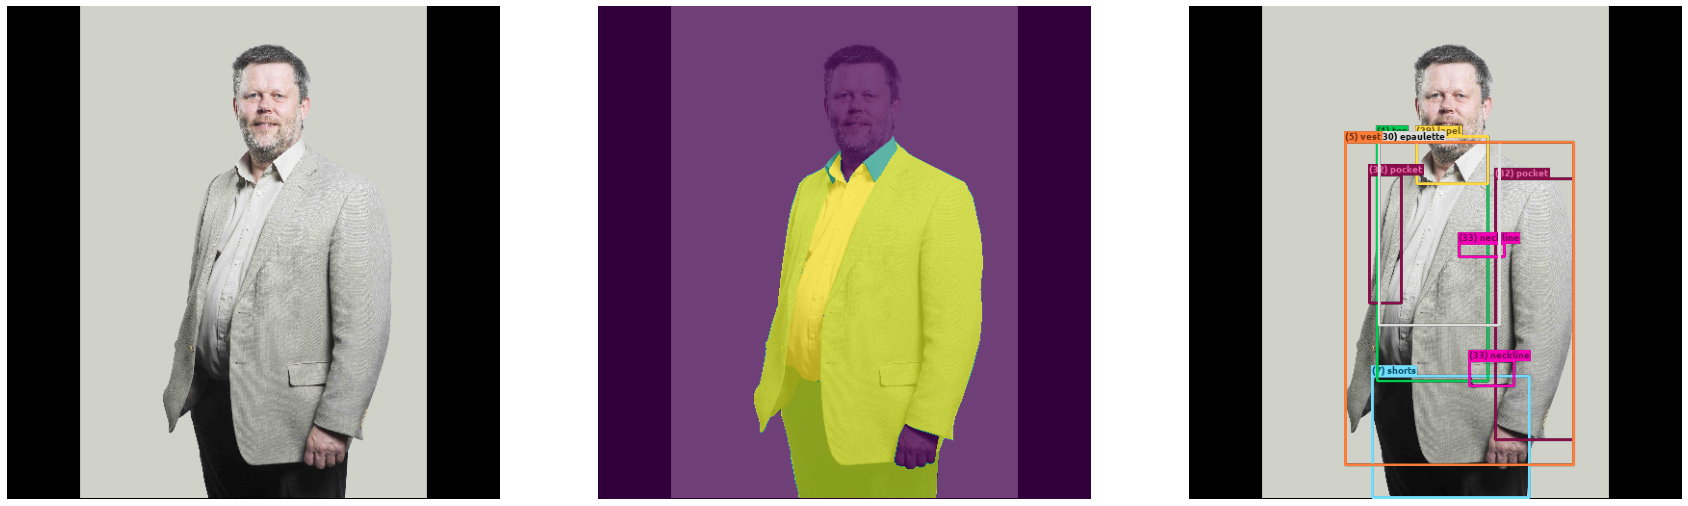

tensor([20538., 29210.,  3626., 21951.,   658.,  1196.,  4389., 23750., 79395.],
       dtype=torch.float64)
tensor([ 7,  1, 29, 32, 33, 33, 32, 30,  5])


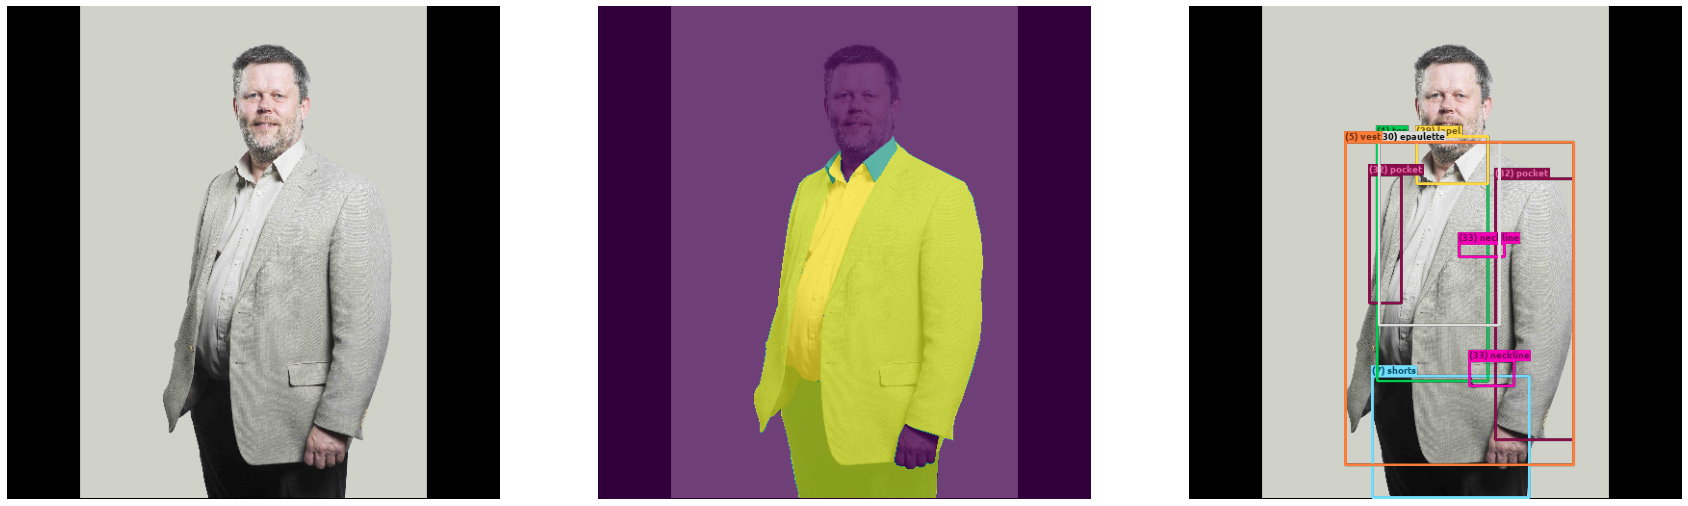

tensor([20538., 29210.,  3626., 21951.,   658.,  1196.,  4389., 23750., 79395.],
       dtype=torch.float64)
tensor([ 7,  1, 29, 32, 33, 33, 32, 30,  5])


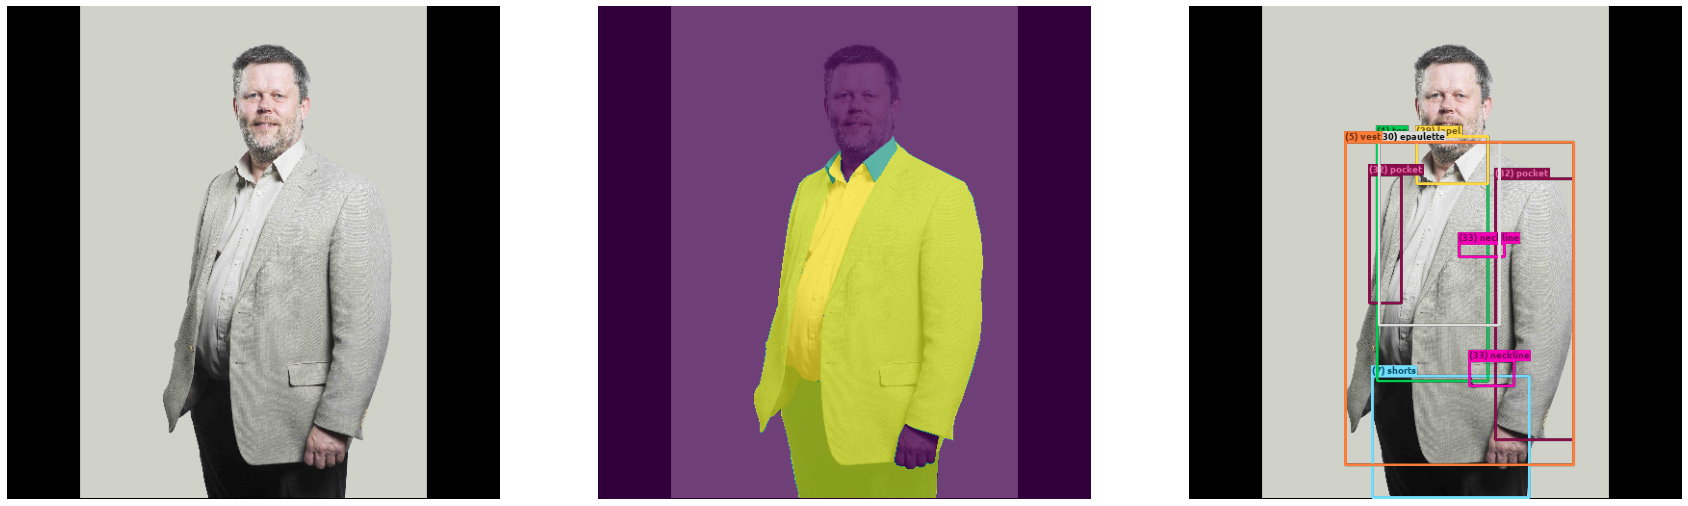

tensor([20538., 29210.,  3626., 21951.,   658.,  1196.,  4389., 23750., 79395.],
       dtype=torch.float64)
tensor([ 7,  1, 29, 32, 33, 33, 32, 30,  5])


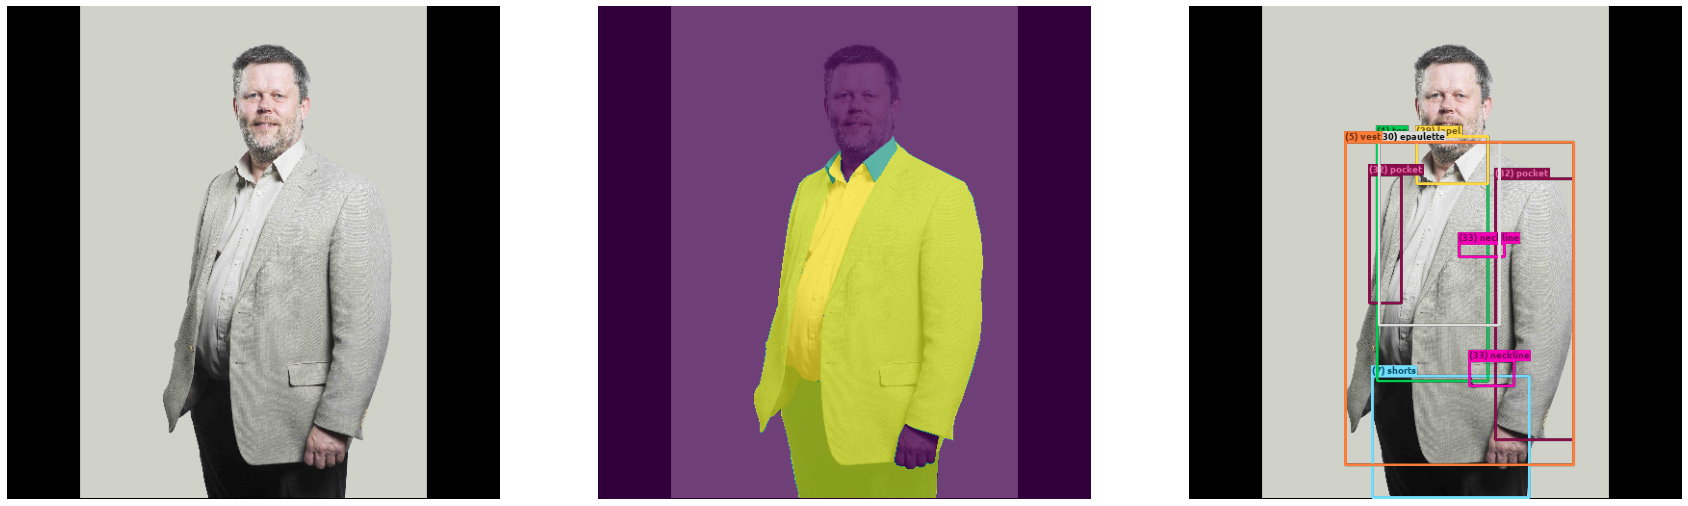

tensor([20538., 29210.,  3626., 21951.,   658.,  1196.,  4389., 23750., 79395.],
       dtype=torch.float64)
tensor([ 7,  1, 29, 32, 33, 33, 32, 30,  5])
--->
20
20
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
Processed [20] images in [0.21757292747497559] seconds.Avg of [0.010878646373748779] per image.
80
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 512, 512])
1.0
torch.Size([3, 5

In [182]:
class IMATDatasetH5PY(BaseDataset):
    def __init__(self, dataset_h5py_reader, transforms=None):
        self.transforms = transforms
        self.lock = Lock()
        self.dataset_h5py_reader = dataset_h5py_reader
        self.images_processed = Value('i', 0)
        self.total_process_time = Value('f', 0.0)
        # TODO: indices = torch.randperm(len(dataset)).tolist()
        
    def show_stats(self):
        images_processed = self.images_processed.value
        total_process_time = self.total_process_time.value
        avg_time_per_image = 0 if images_processed == 0 else total_process_time / images_processed
        print("Processed [{}] images in [{}] seconds."
              "Avg of [{}] per image."
              .format(
            images_processed,
            total_process_time,
            avg_time_per_image))
    
    def __getitem__(self, idx):
        start = time.time()
        
        image, labels, masks, boxes = self.dataset_h5py_reader.__getitem__(idx)
        image = torch.from_numpy(image)
        target = {}
        target["labels"] = torch.from_numpy(labels)
        assert torch.min(target["labels"]) >= 1
        assert torch.max(target["labels"]) <= num_classes
        
        num_objs = target["labels"].shape[0]
        target["masks"] = torch.from_numpy(masks[0:num_objs])
        target["boxes"] = torch.from_numpy(boxes[0:num_objs])
        target["image_id"] = torch.tensor(idx)
        area = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0])
        target["area"] = torch.tensor(area)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target["iscrowd"] = iscrowd
        
        # TODO(ofekp): make sure that this makes sense!
        # TODO(ofekp): check what happens here when the image is < target_dim. What will worker.py scale method do to the image in this case?
        target["img_size"] = (target_dim, target_dim)
        image_orig_max_dim = max(target["img_size"])
        img_scale = target_dim / image_orig_max_dim
        target["img_scale"] = 1. / img_scale  # back to original size
        
        inc_by(self.lock, self.images_processed, 1)
        inc_by(self.lock, self.total_process_time, time.time() - start)
        return image, target
        
#         image_id = self.image_ids[idx]
#         vis_df = self.data_df[self.data_df['ImageId'] == image_id]
#         vis_df = vis_df.reset_index(drop=True)
#         labels = worker.get_labels(vis_df)
#         mask_start_ts = time.time()
#         try:
#             masks = worker.get_masks(vis_df, target_dim=target_dim)
#             for mask in masks:
#                 assert not torch.any(torch.isnan(mask))
#                 assert len(mask.nonzero()) == torch.sum(mask)  # check only ones and zeros
#         except Exception as e:
#             self.skipped_images.append(image_id)
#             print("ERROR: Skipped image with id [{}] due to a mask exception [{}]".format(image_id, e))
#             return
#         inc_by(self.lock, self.total_mask_time, time.time() - mask_start_ts)
        
#         box_start_ts = time.time()
#         boxes = worker.get_bounding_boxes(vis_df, masks)
#         try:
#             for box in boxes:
#                 assert not torch.any(torch.isnan(box))
#         except Exception as e:
#             self.skipped_images.append(image_id)
#             print("ERROR: Skipped image with id [{}] due to a BB exception [{}]".format(image_id, e))
#             return
#         inc_by(self.lock, self.total_box_time, time.time() - box_start_ts)
        
#         num_objs = len(labels)

#         image_id_idx = idx
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

#         labels, masks, boxes = worker.remove_empty_masks(labels, masks, boxes)

# #         target["image_id"] = torch.tensor(image_id_idx)
# #         target["area"] = torch.tensor(area)
# #         target["iscrowd"] = torch.tensor(iscrowd)

#         image_load_start_ts = time.time()
#         image_orig = Image.open(get_image_path(image_id)).convert("RGB")
#         # image = mpimg.imread(get_image_path(image_id))
#         image = worker.rescale(image_orig, target_dim=target_dim)
#         inc_by(self.lock, self.total_image_load_time, time.time() - image_load_start_ts)
        

        
#         transform_start_ts = time.time()
#         if self.transforms is not None:
#             image, target = self.transforms(image, target)
#         inc_by(self.lock, self.total_transform_time, time.time() - transform_start_ts)

#         assert image.shape[0] <= target_dim and image.shape[1] <= target_dim and image.shape[2] <= target_dim
        

    def __len__(self):
        print("--->")
        print(self.dataset_h5py_reader.h5py_file['labels'].len())
        return self.dataset_h5py_reader.h5py_file['labels'].len()
    
# check transforms
for i in range(4):
    h5_reader = DatasetH5Reader("../imaterialist_" + str(target_dim) + ".hdf5")
    dataset = IMATDatasetH5PY(h5_reader, get_transform(train=True))
    for i, (img, target) in enumerate(dataset):
        show_image_data(img, target['labels'], target['masks'], target['boxes'])
        print(target['area'])
        print(target['labels'])
        break
        
h5_reader = DatasetH5Reader("../imaterialist_" + str(target_dim) + ".hdf5")
dataset = IMATDatasetH5PY(h5_reader, get_transform(train=True))
print(len(dataset))
for i, (img, target) in enumerate(dataset):
    print(img.shape)  # print the shape of the image
#     print(d)
#     print(d[1]['boxes'].shape)
#     print(d[1]['labels'].shape)
#     print(d[1]['masks'].shape)
#     print(d[1]['area'].shape)
    print(target['img_scale'])
    if i == 19:
        break
dataset.show_stats()
        
dataset = IMATDataset(train_df, get_transform(train=True))
print(len(dataset))
for i, (img, target) in enumerate(dataset):
    print(img.shape)  # print the shape of the image
#     print(d)
#     print(d[1]['boxes'].shape)
#     print(d[1]['labels'].shape)
#     print(d[1]['masks'].shape)
#     print(d[1]['area'].shape)
    print(target['img_scale'])
    if i == 19:
        break
dataset.show_stats()